# Ejemplo inferencia con TPU

## <span style="color:red">J. Oriol Moreno Usó</span> 

## Librerias

In [1]:
import cv2
import os
import copy
import numpy as np
import time
import matplotlib.pyplot as plt
#import tensorflow as tf

import pycoral
from pycoral.adapters.common import input_details
from pycoral.adapters.common import output_tensor
from pycoral.utils.edgetpu import make_interpreter
from pycoral.utils.edgetpu import run_inference

## Carga modelo e imagen

In [2]:
def get_images(path):
    path_content = os.listdir(path)
    images = []
    for img_name in path_content:
        img = cv2.imread(path + img_name, cv2.IMREAD_GRAYSCALE)
        #im_bw = cv2.threshold(img, 128, 255, cv2.THRESH_BINARY)[1]
        img = cv2.resize(img, (28, 28))
        images.append(img)

    return np.array(images)

x_test = get_images("./data/test/")

x_test = x_test.astype('float32') / 255.
#x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

In [3]:
x_test.shape

(10000, 28, 28, 1)

Dado que pycoral es incompatible con cualquier tipo de carga de tensorflow o keras, la única forma de cargar los datos es cargarlos desde local.

In [4]:
# Paths a los dos modelos
model_path_quant = "./quant_models/cnn_AE_mnist_quant_1.1_int8_edgetpu.tflite"
model_path = "./models/cnn_AE_mnist_quant_1.1_int8.tflite"

## Modelo sin operaciones en tpu

In [19]:
interpreter = make_interpreter(model_path) # Genereramos/cargamos el objeto modelo
interpreter.allocate_tensors() # Lo enviamos a TPU
inference_size = input_details(interpreter, 'shape') # Recogemos el input shape del modelo

En este caso, no se envía ninguna operación a TPU puesto que el modelo no está compilado para TPU.

### Reconstrucción/Inferencia

In [20]:
t1 = time.time()
images = [] # Lista para guardar la reconstruccion de cada imagen

for img in x_test:
    #cv2_im = cv2.resize(img, inference_size) # Cambio de shape para que encaje con el tamaño de input
    run_inference(interpreter, img.tobytes()) # Inferencia
    reconstruction = output_tensor(interpreter,0) # Recogemos la reconstrucción
    img_rec = copy.copy(reconstruction) # Hacemos una copia de cada imagen reconstruída dado que reconstruction es mutable
    images.append(img_rec) # Añadimos cada imagen reconstruida a la lista
print(f"Execute time: {round(time.time() - t1, 2)} segs")

Execute time: 137.86 segs


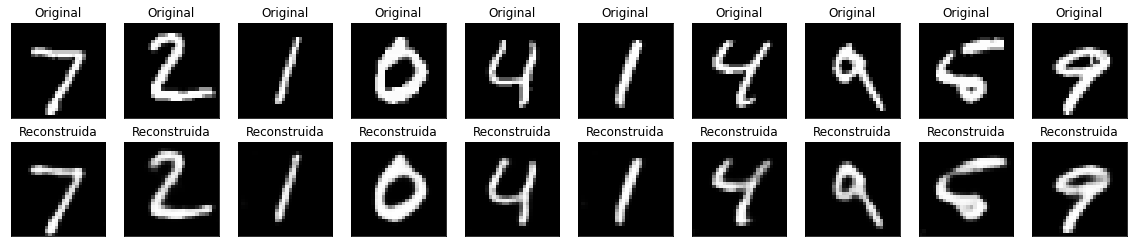

In [8]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    plt.title("Original")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruccion
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(images[i].reshape(28, 28))
    plt.gray()
    plt.title("Reconstruida")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## Modelo compilado para TPU

In [17]:
interpreter = make_interpreter(model_path_quant) # Genereramos/cargamos el objeto modelo
interpreter.allocate_tensors() # Lo enviamos a TPU
inference_size = input_details(interpreter, 'shape') # Recogemos el input shape del modelo

### Reconstrucción/Inferencia

In [18]:
t1 = time.time()
images = [] # Lista para guardar la reconstruccion de cada imagen

for img in x_test:
    #cv2_im = cv2.resize(img, inference_size) # Cambio de shape para que encaje con el tamaño de input
    run_inference(interpreter, img.tobytes()) # Inferencia
    reconstruction = output_tensor(interpreter,0) # Recogemos la reconstrucción
    img_rec = copy.copy(reconstruction) # Hacemos una copia de cada imagen reconstruída dado que reconstruction es mutable
    images.append(img_rec) # Añadimos cada imagen reconstruida a la lista
print(f"Execute time: {round(time.time() - t1, 2)} segs")

Execute time: 6.78 segs


In [14]:
t1 = time.time()
images = np.empty((x_test.shape)) # Lista para guardar la reconstruccion de cada imagen

for idx, img in enumerate(x_test):
    #cv2_im = cv2.resize(img, inference_size) # Cambio de shape para que encaje con el tamaño de input
    run_inference(interpreter, img.tobytes()) # Inferencia
    images[idx] = output_tensor(interpreter,0) # Recogemos la reconstrucción
print(f"Execute time: {round(time.time() - t1, 2)} segs")

Execute time: 6.94 segs


El uso de np.arrays es mucho más eficiente que el uso de listas.

Puesto que el *batch* que acepta el modelo es *(1, 28, 28, 1)* tenemos que enviar las imágenes de una en una,    
y como *reconstruction* es mutable, hace falta una copia real (no link) para poder guardar cada imagen reconstruida.

Como podemos observar, la diferencia de tiempo en inferencia entre el modelo en CPU y TPU es en este caso de x17.

Para una aproximación más óptima, es interesante observar cual es el tamaño de *batch* que minimiza el tiempo de inferencia.

### Observarmos las reconstrucciones frente a las originales

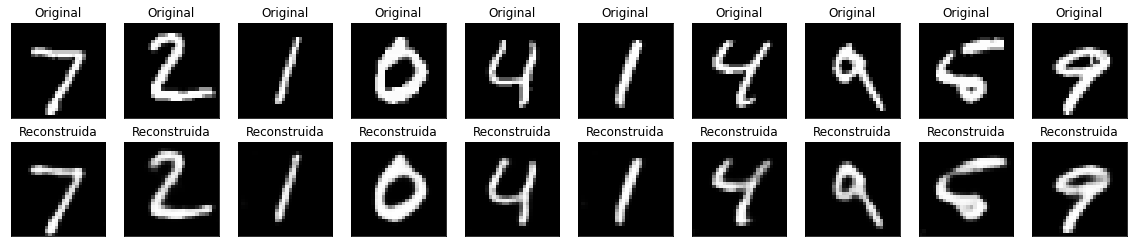

In [12]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    plt.title("Original")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruccion
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(images[i].reshape(28, 28))
    plt.gray()
    plt.title("Reconstruida")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()